Create a GAN model to generate images of Fashion MNIST. GAN Architecture diagram below:

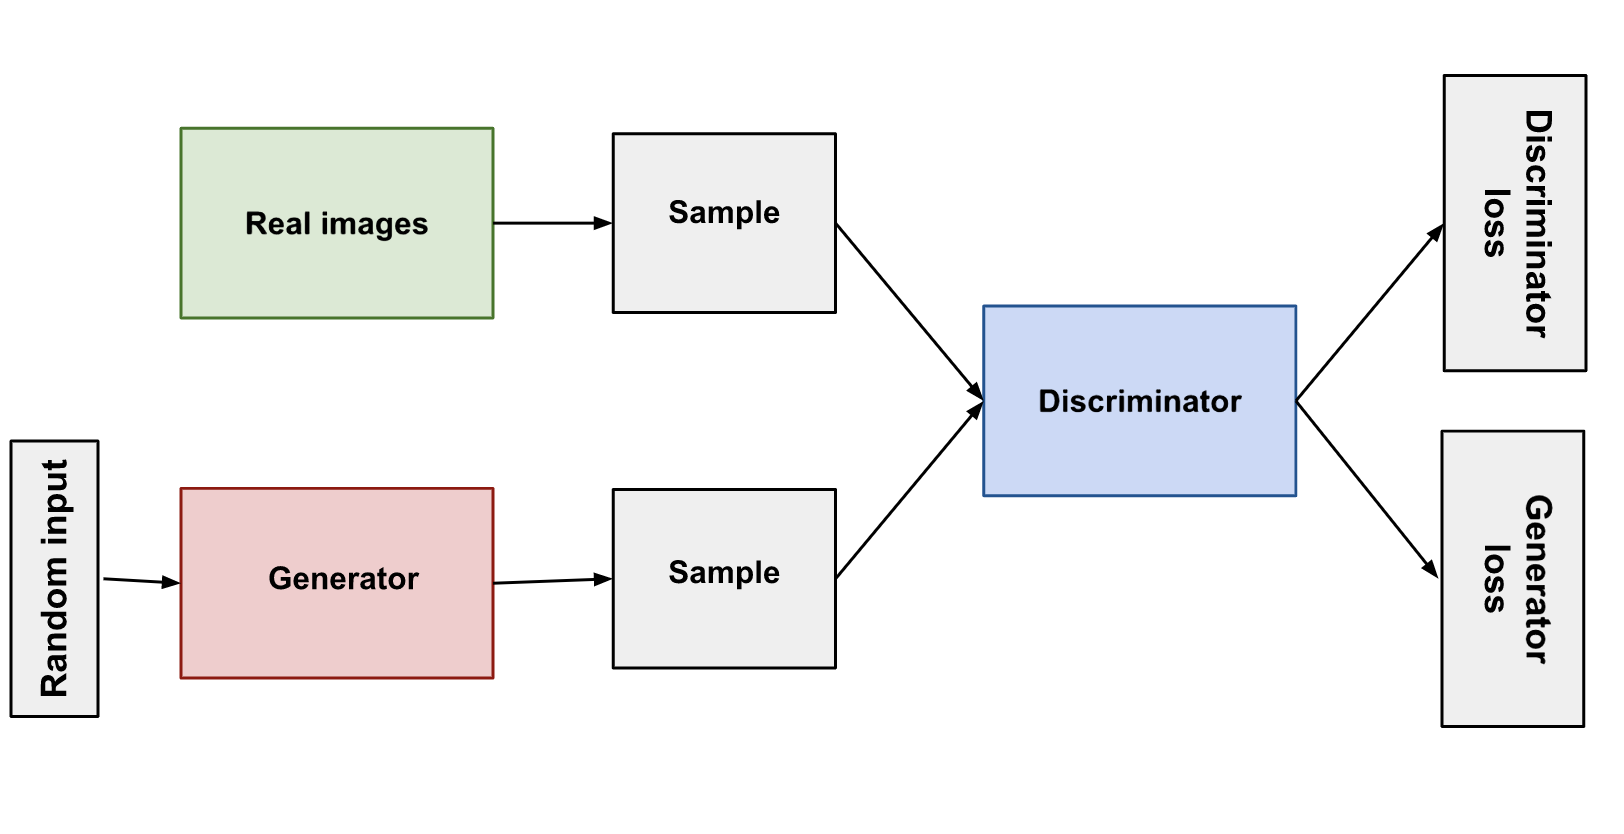

In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
#import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from IPython import display
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from tqdm.auto import tqdm


num_epochs = 100
batch_size = 100
lrate = 0.0002
lat_dimension=64
image_sz=64
chnls=1
logging_intv=200

In [2]:
datasets = torchvision.datasets.FashionMNIST(root = '/Users/apple/Downloads',
                      transform = transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize([0.5],[0.5])
                      ]),
                      train = True, download = True)
data_loader = torch.utils.data.DataLoader(datasets, shuffle = True, batch_size = batch_size)

num_batches = int(len(datasets)/batch_size)
print('Batch size :{}, number of batches in one epoch :{}'.format(batch_size, num_batches))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /Users/apple/Downloads/FashionMNIST/raw/train-images-idx3-ubyte.gz to /Users/apple/Downloads/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /Users/apple/Downloads/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /Users/apple/Downloads/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /Users/apple/Downloads/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /Users/apple/Downloads/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /Users/apple/Downloads/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/apple/Downloads/FashionMNIST/raw

Batch size :100, number of batches in one epoch :600


Display Some sample examples

torch.Size([1, 28, 28])


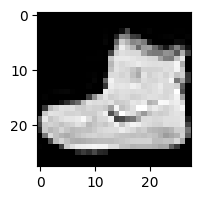

In [5]:
a = datasets[0][0]
def show(img):
    """Given the image tensor, show the gray image.
    """
    img = img.view(28,28)
    plt.figure(figsize=(2,2))
    plt.imshow(img,cmap = 'gray')
    plt.show()
    return

def show_grid(images, title = None, rows = 4):
    """Given the images tensors, show the multiple images
    """
    num = images.size(0)
    
    fig = plt.figure(figsize= (5,5))
    plt.title(title)
    cols = int(num/rows)
    
    for i in range(1, num+1):
        img = images[i-1].view(28,28)
        fig.add_subplot(rows, cols, i)
        plt.axis('off')
        plt.imshow(img, cmap = 'gray')
    
    plt.show()
    return

print(a.size())
show(a)

torch.Size([100, 1, 28, 28])


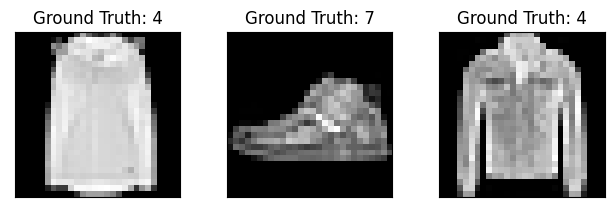

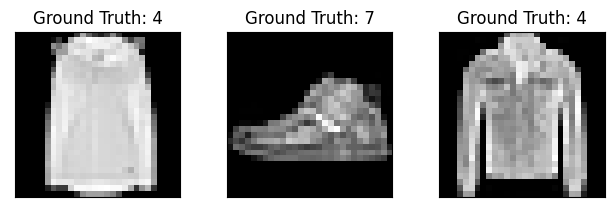

In [17]:
samples = enumerate(data_loader)
batch_idx, (sample_data, sample_target) = next(samples)
sample_data.shape

print(sample_data.shape)
fig = plt.figure()
for i in range(3):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(sample_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(sample_target[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Discriminator Class

In [18]:
class DiscriminatorNet(nn.Module):
    
    def __init__(self):
        super(DiscriminatorNet,self ).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.layer_out = nn.Linear(256,1)
        
    def forward(self, x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = F.sigmoid(self.layer_out(x))
        
        return x


# Generator Class

In [19]:
class GeneratorNet(nn.Module):
    
    def __init__(self):
        super(GeneratorNet,self).__init__()
        
        self.num_features = 100
        
        self.layer1 = nn.Sequential(
            nn.Linear(self.num_features, 256),
            nn.LeakyReLU(0.2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(256,512),
            nn.LeakyReLU(0.2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        
        )
        
        self.layer_out = nn.Sequential(
            nn.Linear(1024, 784),
            nn.Tanh()
        )
        
    def forward(self, x):

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer_out(x)

        return x

In [20]:
### Instantiate the model class
Dis_model = DiscriminatorNet()
Gen_model = GeneratorNet()

### Put the model to the gpu if possible
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

if torch.cuda.device_count() > 1:
    Dis_model = nn.DataParallel(Dis_model).cuda()
    Gen_model = nn.DataParallel(Gen_model).cuda()
    
    torch.backends.cudnn.benchmark = True
    
Dis_model.to(device)
Gen_model.to(device)

print('The structure of discriminator:\n',Dis_model, '\nThe structure of generator:\n',Gen_model)

cpu
The structure of discriminator:
 DiscriminatorNet(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (layer_out): Linear(in_features=256, out_features=1, bias=True)
) 
The structure of generator:
 GeneratorNet(
  (layer1): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (layer3): Sequential(
    (0): Linear(in_features=512, out_features

In [21]:
dis_optimizer = torch.optim.Adam(Dis_model.parameters(), lr = 0.0002)
gen_optimizer = torch.optim.Adam(Gen_model.parameters(), lr = 0.0002)

criterion = nn.BCELoss()

def real_label(real_data):
    """Generate real data labels
    """
    num = real_data.size(0)
    labels = Variable(torch.ones(num,1)).to(device)
    
    return labels

def fake_label(fake_data):
    """Generate fake data labels
    """
    num = fake_data.size(0)
    labels = Variable(torch.zeros(num,1)).to(device)
    
    return labels

In [23]:
def train_dis(model,optimizer, real_data, fake_data):
    
    optimizer.zero_grad()
    
    # train on real data
    real_preds = model(real_data)
    loss_real = criterion(real_preds, real_label(real_data))
    loss_real.backward()
    
    # train on fake data
    fake_preds = model(fake_data)
    loss_fake = criterion(fake_preds, fake_label(fake_data))
    loss_fake.backward()
    
    loss_D = loss_real + loss_fake
    # update
    optimizer.step()
    
    return loss_D, real_preds, fake_preds
    
def train_gen(model, optimizer, fake_data):
    
    # reset optimizer
    optimizer.zero_grad()
    
    # sample noise and generate fake_data
    preds = model(fake_data)
    
    loss = criterion(preds, real_label(preds))
    loss.backward()

    optimizer.step()
    return loss,preds

def noise(size):
    n = Variable(torch.randn(size, 100)).to(device)
    return n

num_test_samples = 16
test_noise = noise(num_test_samples)

  0%|          | 0/50 [00:00<?, ?it/s]

/opt/anaconda3/envs/tf/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch:0, iters:599, loss_D:0.13672980666160583, loss_G:5.77067756652832
D(x):0.9734641313552856, D(G(z1)):0.07355739176273346, D(G(z2):0.04939167946577072)


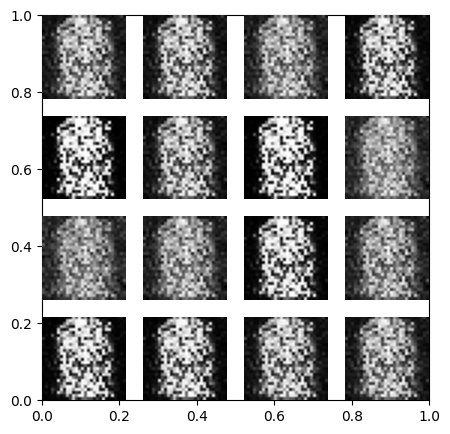

epoch:1, iters:1199, loss_D:0.7280408143997192, loss_G:2.1220293045043945
D(x):0.7903719544410706, D(G(z1)):0.24922627210617065, D(G(z2):0.21314553916454315)
epoch:2, iters:1799, loss_D:0.39763593673706055, loss_G:3.5841519832611084
D(x):0.9021003842353821, D(G(z1)):0.09818987548351288, D(G(z2):0.0742359310388565)
epoch:3, iters:2399, loss_D:0.562884509563446, loss_G:3.1430177688598633
D(x):0.8331878185272217, D(G(z1)):0.17352186143398285, D(G(z2):0.0987207442522049)
epoch:4, iters:2999, loss_D:0.5813065767288208, loss_G:2.4087939262390137
D(x):0.7952479720115662, D(G(z1)):0.1842712014913559, D(G(z2):0.14562314748764038)
epoch:5, iters:3599, loss_D:0.559228777885437, loss_G:2.20324444770813
D(x):0.8300897479057312, D(G(z1)):0.21129873394966125, D(G(z2):0.18644046783447266)
epoch:6, iters:4199, loss_D:0.8609921932220459, loss_G:1.4050548076629639
D(x):0.7746017575263977, D(G(z1)):0.34033533930778503, D(G(z2):0.318820983171463)
epoch:7, iters:4799, loss_D:0.50849848985672, loss_G:2.90888

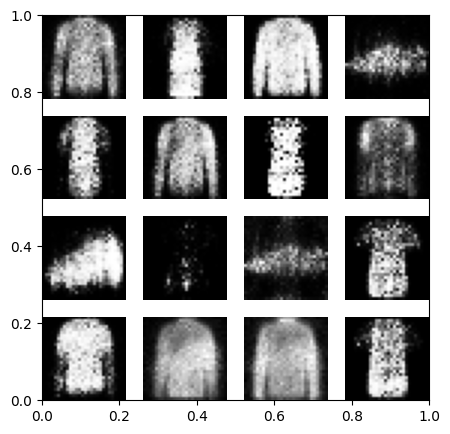

epoch:11, iters:7199, loss_D:0.8441815376281738, loss_G:1.5077450275421143
D(x):0.7696972489356995, D(G(z1)):0.3129523992538452, D(G(z2):0.300406813621521)
epoch:12, iters:7799, loss_D:0.825825572013855, loss_G:1.5727466344833374
D(x):0.7000298500061035, D(G(z1)):0.2771758735179901, D(G(z2):0.26943182945251465)
epoch:13, iters:8399, loss_D:0.9822203516960144, loss_G:1.8714677095413208
D(x):0.7032666206359863, D(G(z1)):0.2853512465953827, D(G(z2):0.2107296735048294)
epoch:14, iters:8999, loss_D:0.8561089038848877, loss_G:1.4888588190078735
D(x):0.7733020782470703, D(G(z1)):0.3179752826690674, D(G(z2):0.2933170199394226)
epoch:15, iters:9599, loss_D:0.8671389222145081, loss_G:1.7715752124786377
D(x):0.7137364149093628, D(G(z1)):0.26692768931388855, D(G(z2):0.22238606214523315)
epoch:16, iters:10199, loss_D:0.9921786785125732, loss_G:1.6793434619903564
D(x):0.7013612389564514, D(G(z1)):0.2820602357387543, D(G(z2):0.26814723014831543)
epoch:17, iters:10799, loss_D:1.0041166543960571, loss_

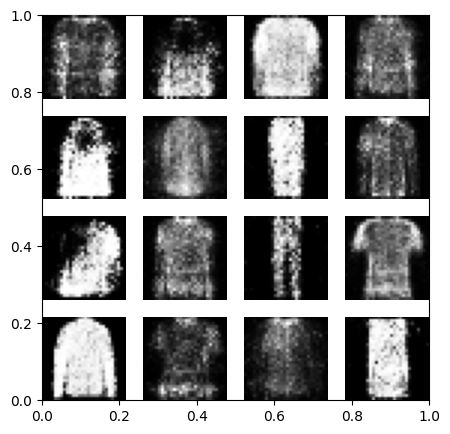

epoch:21, iters:13199, loss_D:0.9444694519042969, loss_G:1.6445773839950562
D(x):0.6864240765571594, D(G(z1)):0.3161828815937042, D(G(z2):0.24505068361759186)
epoch:22, iters:13799, loss_D:0.9123430252075195, loss_G:1.4769340753555298
D(x):0.6448544859886169, D(G(z1)):0.26287642121315, D(G(z2):0.26871874928474426)
epoch:23, iters:14399, loss_D:0.8528320789337158, loss_G:1.647170066833496
D(x):0.6719521880149841, D(G(z1)):0.22992455959320068, D(G(z2):0.24477483332157135)
epoch:24, iters:14999, loss_D:0.7914503812789917, loss_G:1.3129147291183472
D(x):0.7471513152122498, D(G(z1)):0.2885260581970215, D(G(z2):0.3130750358104706)
epoch:25, iters:15599, loss_D:0.8246985673904419, loss_G:1.6391916275024414
D(x):0.7653701305389404, D(G(z1)):0.29998013377189636, D(G(z2):0.2550526261329651)
epoch:26, iters:16199, loss_D:1.075171947479248, loss_G:1.2336599826812744
D(x):0.658955991268158, D(G(z1)):0.36068955063819885, D(G(z2):0.33440694212913513)
epoch:27, iters:16799, loss_D:0.9733151793479919, 

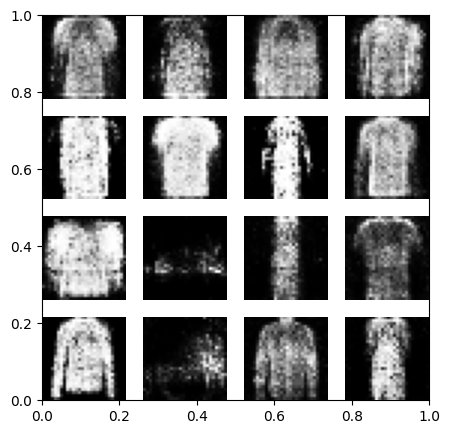

epoch:31, iters:19199, loss_D:0.9739595651626587, loss_G:1.3448578119277954
D(x):0.6781165599822998, D(G(z1)):0.32202884554862976, D(G(z2):0.2965601980686188)
epoch:32, iters:19799, loss_D:0.9174036979675293, loss_G:1.5645325183868408
D(x):0.6736438274383545, D(G(z1)):0.3014475107192993, D(G(z2):0.2496567666530609)
epoch:33, iters:20399, loss_D:0.9889662265777588, loss_G:1.3381184339523315
D(x):0.6661233305931091, D(G(z1)):0.3166014850139618, D(G(z2):0.29794061183929443)
epoch:34, iters:20999, loss_D:0.9840859174728394, loss_G:1.3378136157989502
D(x):0.7062312960624695, D(G(z1)):0.3633686304092407, D(G(z2):0.3181496858596802)
epoch:35, iters:21599, loss_D:0.895748496055603, loss_G:1.592775821685791
D(x):0.7097983360290527, D(G(z1)):0.3113156259059906, D(G(z2):0.25792840123176575)
epoch:36, iters:22199, loss_D:1.0806396007537842, loss_G:1.337717890739441
D(x):0.5780810713768005, D(G(z1)):0.28749969601631165, D(G(z2):0.2929113209247589)
epoch:37, iters:22799, loss_D:1.0502020120620728, l

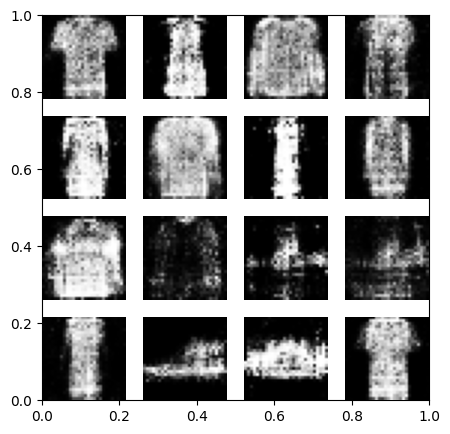

epoch:41, iters:25199, loss_D:1.1421430110931396, loss_G:1.160677194595337
D(x):0.6237320303916931, D(G(z1)):0.39921829104423523, D(G(z2):0.3401097059249878)
epoch:42, iters:25799, loss_D:0.9261767864227295, loss_G:1.2119592428207397
D(x):0.6839837431907654, D(G(z1)):0.333082914352417, D(G(z2):0.328114777803421)
epoch:43, iters:26399, loss_D:0.9957375526428223, loss_G:1.1841282844543457
D(x):0.6540928483009338, D(G(z1)):0.32628849148750305, D(G(z2):0.3467821180820465)
epoch:44, iters:26999, loss_D:1.083886742591858, loss_G:1.1032034158706665
D(x):0.6315814852714539, D(G(z1)):0.36964184045791626, D(G(z2):0.36775538325309753)
epoch:45, iters:27599, loss_D:1.2157936096191406, loss_G:1.2568211555480957
D(x):0.6360614895820618, D(G(z1)):0.36918026208877563, D(G(z2):0.3183777928352356)
epoch:46, iters:28199, loss_D:0.8776472806930542, loss_G:1.091665267944336
D(x):0.7274129390716553, D(G(z1)):0.36905619502067566, D(G(z2):0.3644527196884155)
epoch:47, iters:28799, loss_D:0.9554029703140259, l

In [24]:
num_epochs = 50

for epoch in tqdm(range(num_epochs)):
    
    for batch_idx, (real_images, _) in enumerate(data_loader):
        
        ### 1. Train the discriminator
        real_images = Variable(real_images.view(-1,28*28)).to(device)
        
        #generate the fake data
        fake_images = Gen_model(noise(real_images.size(0))).detach()
        
        # train the discriminator
        loss_D, real_preds, fake_preds = train_dis(Dis_model, dis_optimizer, real_images, fake_images)
        
        D_x = real_preds.mean().item()
        D_G1 = fake_preds.mean().item()
        
        ### 2. Train the generator
        fake_images = Gen_model(noise(real_images.size(0)))
        # train the generator
        loss_G, preds = train_gen(Dis_model, gen_optimizer, fake_images)
        
        D_G2 = preds.mean().item()
    
    # show the loss every epoch
    print('epoch:{}, iters:{}, loss_D:{}, loss_G:{}'.format(epoch, batch_idx +epoch*num_batches , loss_D.item(), loss_G.item()))
    print('D(x):{}, D(G(z1)):{}, D(G(z2):{})'.format(D_x, D_G1, D_G2))

    # show the test images every 10 epochs
    if epoch%10 ==0:
        test_imgs = Gen_model(test_noise).cpu().detach()
        show_grid(test_imgs)
        
        

# Save the model

In [25]:
filepath = '/Users/apple/Documents/gan_model/DCGAN_fashion_MNIST_model_v1.pth'
state = {
    'epoch': num_epochs,
    'state_dict': Gen_model.state_dict(),
    'optimizer': gen_optimizer.state_dict()
   
}
torch.save(state, filepath)